In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import operator
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

# Some info about what our questions are

## First we will clean the data

In [2]:
columns = ['Artist', 'Title', 'Album', '#_of_views', 'Release_date', '#_feat_artists', 
           'Artist_pop', 'Genre', 'Followers', 'Danceability', 'Track_pop', 'Explicit', 
           'Energy', 'Valence', 'Duration', 'Loudness', '#_words', 'Lyrics']
data = pd.read_csv('lyricDatasetUpdated.csv', names = columns)

Based on the greatest similarity between track titles, the data from Spotify was concatenated to the current Genius dataset. Now the dataset has additional features from Spotify. Some of the feature descriptions are grabbed straight from the Spotify API. The full list of features are as follow:<br>

1. **`Artist`** - Song artist<br>
DESCRIPTION: Name of artist
2. **`Title`** - Song title<br>
DESCRIPTION: Name of song
3. **`Album`** - Album Title<br>
DESCRIPTION: Name of album the song is from.
4. **`#_of_views`** - Number of pageviews for the lyric<br>
DESCRIPTION: Amount of views the lyric page got on the Genius website.
5. **`Release_date`** - Release date of song<br>
DESCRIPTION: The date the song was released
6. **`#_feat_artists`** - How many featured artists<br>
DESCRIPTION: The amount of artists featured on song
7. **`Artist_pop`** - Artist Popularity<br>
DESCRIPTION: How popular an artist is on Spotify. Range is 0-100.
8. **`Genre`** - Genre(s)<br>
DESCRIPTION: Genre the artist is considered as, separated by ' / '.
9. **`Followers`**<br>
DESCRIPTION: The amount of users following an artist on Spotify
10. **`Danceability`**<br>
DESCRIPTION: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. (Gotten from Spotify)
11. **`Track_pop`**<br>
DESCRIPTION: Track popularity is separate from artist popularity. It's the metric grabbed from Spotify on how popular a track is.
12. **`Explicit`**<br>
DESCRIPTION: If a song has lyrics on mature themes, or foul language, it is considered explicit. This is a binary value.
13. **`Energy`**<br>
DESCRIPTION: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
14. **`Valence`**<br>
DESCRIPTION: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
15. **`Duration`** - Duration (in Milliseconds)<br>
DESCRIPTION: The length of the song in milliseconds
16. **`Loudness`**<br>
DESCRIPTION: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
17. **`#_words`** - Total words in lyrics<br>
DESCRIPTION: How many words each lyric has.
18. **`Lyrics`**<br>
DESCRIPTION: The lyrics for the specific song.

In [3]:
data['Genre'].fillna('hip hop', inplace = True)

In [4]:
data.dropna(subset = ['Lyrics'], inplace = True)
data.reset_index(drop = True, inplace = True)

In [5]:
genres = data['Genre']
g_list = list(genres)
genre_list = ['country', 'hip hop', 'pop', 'rock', 'punk', 'metal', 
              'australian'] #Australian reggae is outlier

In [6]:
correct_guesses = {}
for index, genre in enumerate(g_list):
    if type(genre) == float:
        continue
    else:
        if len(genre) == 1:
            print(genre)
            split_genres = genre
        else:
            split_genres = genre.split(' / ') 
    for g in genre_list:
        correct = 0
        if len(split_genres) == 1 and split_genres[0] == 'rap':
            correct_guesses['hip hop'] = correct
        else:
            for split in split_genres:
                if g in split:
                    correct += 1
            correct_guesses[g] = correct
    
    correct_genre = max(correct_guesses, key=lambda key: correct_guesses[key])
    if correct_genre == 'australian':
        g_list[index] = 'pop'
    elif correct_genre == 'punk':
        g_list[index] = 'rock'
    else:
        g_list[index] = correct_genre
    correct_guesses.clear()

In [7]:
data['Genre'] = g_list

In [8]:
data['Lyrics'] = data['Lyrics'].astype(str)
data['Lyrics'] = data['Lyrics'].str.lower()
data['Lyrics'] = data['Lyrics'].str.translate(string.punctuation)
data['Lyrics'] = data['Lyrics'].str.replace('+', ' ').replace('\\', '').replace('"', '')

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = []
analyzer = SentimentIntensityAnalyzer()
for label, content in data['Lyrics'].items():
    sentiment.append(analyzer.polarity_scores(content))

In [10]:
neg = []
neu = []
pos = []
compound = []

In [11]:
for sentiments in sentiment:
    neg.append(sentiments['neg'])
    neu.append(sentiments['neu'])
    pos.append(sentiments['pos'])
    compound.append(sentiments['compound'])

In [12]:
data['negative_score'] = neg
data['neutral_score'] = neu
data['positive_score'] = pos
data['compound_score'] = compound

# Classification goes below here
We will conduct some experiments on which models to use, and which feature combinations work best with these models.

# Predict Popularity

In [13]:
data.head(1)

,Artist,Title,Album,#_of_views,Release_date,#_feat_artists,Artist_pop,Genre,Followers,Danceability,...,Energy,Valence,Duration,Loudness,#_words,Lyrics,negative_score,neutral_score,positive_score,compound_score
0,Miranda Lambert,Vice,The Weight of These Wings,42261,2016-07-18,0,72,country,2205152,0.568,...,0.562,0.247,240280,-7.775,233,sting of the needle dropping on a vinyl neon s...,0.034,0.868,0.098,0.9311


In [14]:
data_pop = data.loc[:,'Danceability':'Loudness']

In [15]:
data_pop['Genre'] = data['Genre']

In [16]:
data_pop.isnull().sum()

Danceability     0
Track_pop        0
Explicit        16
Energy           0
Valence          0
Duration         0
Loudness         0
Genre            0
dtype: int64

In [17]:
data_pop.dropna(subset = ['Explicit'], inplace = True)
data_pop.reset_index(drop = True, inplace = True)

In [18]:
data_pop['Explicit'] = data_pop['Explicit'].astype(int)

In [19]:
data_pop = pd.concat([data_pop, pd.get_dummies(data_pop['Genre'], 
                    dummy_na=True)], axis = 1).drop(['Genre'], axis = 1)

In [20]:
data_pop.head(1)

,Danceability,Track_pop,Explicit,Energy,Valence,Duration,Loudness,country,hip hop,metal,pop,rock,NaN
0,0.568,57,0,0.562,0.247,240280,-7.775,1,0,0,0,0,0


In [21]:
from sklearn.datasets import load_boston
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
import itertools    
import numpy as np

In [23]:
pipeline = make_pipeline(StandardScaler(), SGDRegressor())
X = data_pop.drop(['Track_pop'], axis = 1)
y = data_pop['Track_pop']

pipeline.fit(X = X, y = y)
    
scores = cross_val_score(pipeline, X = X, y = y, cv = 5)
scores

array([-0.04957238,  0.05014518,  0.10712958,  0.06261133,  0.06319604])

In [24]:
data.dtypes

Artist             object
Title              object
Album              object
#_of_views          int64
Release_date       object
#_feat_artists      int64
Artist_pop          int64
Genre              object
Followers           int64
Danceability      float64
Track_pop           int64
Explicit           object
Energy            float64
Valence           float64
Duration            int64
Loudness          float64
#_words             int64
Lyrics             object
negative_score    float64
neutral_score     float64
positive_score    float64
compound_score    float64
dtype: object

In [25]:
## Dim above and Chris below

In [26]:
X = data.drop(['Genre', 'Artist', 'Title', 'Album', 'Release_date', '#_feat_artists', 'Explicit', 'Lyrics'], axis = 1)
y = data['Genre']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = 5))
dtree_model = pipeline.fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
cm = confusion_matrix(y_test, dtree_predictions)

In [28]:
#for index, record in enumerate(X_test.iterrows()):
#    print('Predicted genre is:', dtree_predictions[index], '\nReal genre is:', data.iloc[record[0]]['Genre'], '\n')

In [32]:
## Below is mine 
# Source : https://github.com/alikaratana/Music-Genre-Classification/blob/master/GenreClassificationTutorial.ipynb
genre_list

['country', 'hip hop', 'pop', 'rock', 'punk', 'metal', 'australian']

In [35]:
def confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_cnf(model,dataset_x,dataset_y,the_y):
    true_y=dataset_y
    true_x=dataset_x
    pred=model.predict(true_x)

    print("---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------\n")

    print("Real Test dataset labels: \n{}\n".format(true_y))
    print("Predicted Test dataset labels: \n{}".format(pred))

    cnf_matrix=metrics.confusion_matrix(true_y,pred)
    plt.figure()
    a=confusion_matrix(cnf_matrix,classes=genre_list,title='Confusion matrix')

Max Accuracy is 0.911 on test dataset with 1 neighbors.

Training Score: 1.000
Test score: 0.911
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
1831       rock
361     hip hop
1191    country
2245    hip hop
2534        pop
         ...   
1949      metal
2890        pop
1618       rock
1555    hip hop
402       metal
Name: Genre, Length: 753, dtype: object

Predicted Test dataset labels: 
['rock' 'hip hop' 'country' 'hip hop' 'pop' 'metal' 'rock' 'pop' 'hip hop'
 'rock' 'hip hop' 'rock' 'rock' 'metal' 'rock' 'pop' 'pop' 'metal' 'metal'
 'hip hop' 'hip hop' 'country' 'hip hop' 'hip hop' 'pop' 'metal' 'country'
 'hip hop' 'pop' 'rock' 'hip hop' 'pop' 'rock' 'rock' 'hip hop' 'metal'
 'pop' 'country' 'pop' 'country' 'country' 'country' 'metal' 'rock'
 'metal' 'pop' 'rock' 'rock' 'rock' 'metal' 'pop' 'metal' 'hip hop'
 'hip hop' 'country' 'rock' 'metal' 'hip hop' 'hip hop' 'hip hop'
 'hip hop' 'metal' 'rock' 'pop' 'hip hop' 'country' 'rock' 'c

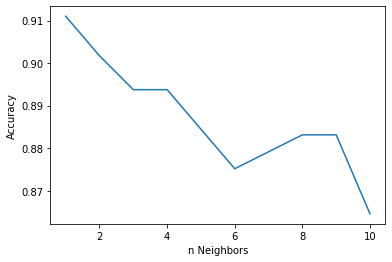

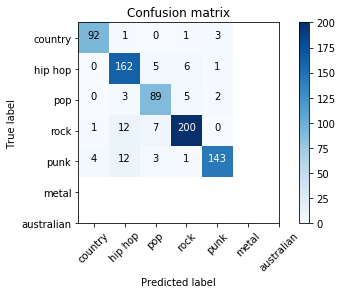

In [36]:
results_knn=[]
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    results_knn.append(knn.score(X_test,y_test))
    
max_accuracy_knn = max(results_knn)
best_k = 1 + results_knn.index(max(results_knn))

print("Max Accuracy is {:.3f} on test dataset with {} neighbors.\n".format(max_accuracy_knn,best_k))

plt.plot(np.arange(1,11),results_knn)
plt.xlabel("n Neighbors")
plt.ylabel("Accuracy")


knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train,y_train)
print("Training Score: {:.3f}".format(knn.score(X_train,y_train)))
print("Test score: {:.3f}".format(knn.score(X_test,y_test)))  

plot_cnf(knn,X_test,y_test,y)